In [1]:
# mount drive to work with google drive
# Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
%cd /content
os.chdir('/content/drive/MyDrive/AAAI/') #path was adjusted manually

Mounted at /content/drive/
/content


1. **Background Subtraction**:
   - If you're working with a video stream, first apply a background subtraction algorithm. This will give you the foreground objects in each frame. Tools like OpenCV have functions like `createBackgroundSubtractorMOG2()` for this.

## **Show the original GIF**

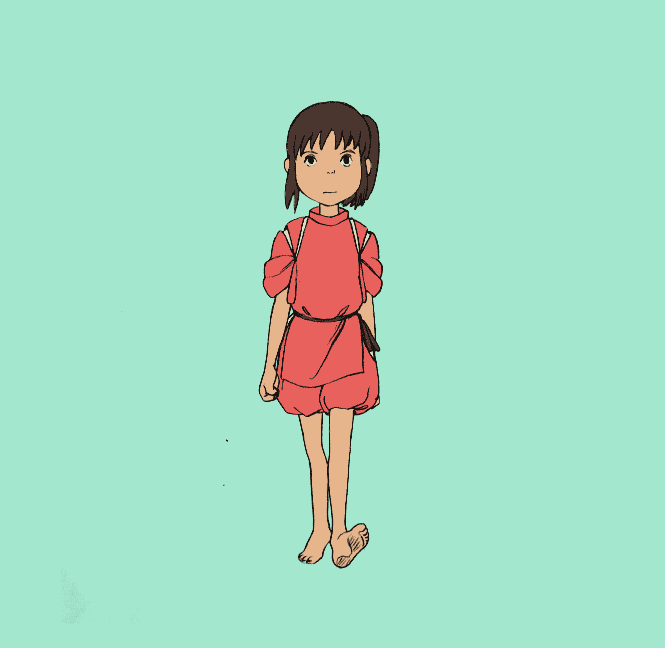

In [2]:
from IPython.display import display, Image

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/girl.gif"

# Display the GIF
with open(input_gif_path, "rb") as f:
    display(Image(data=f.read(), format='png'))


## **Split into Frames, count them**

24


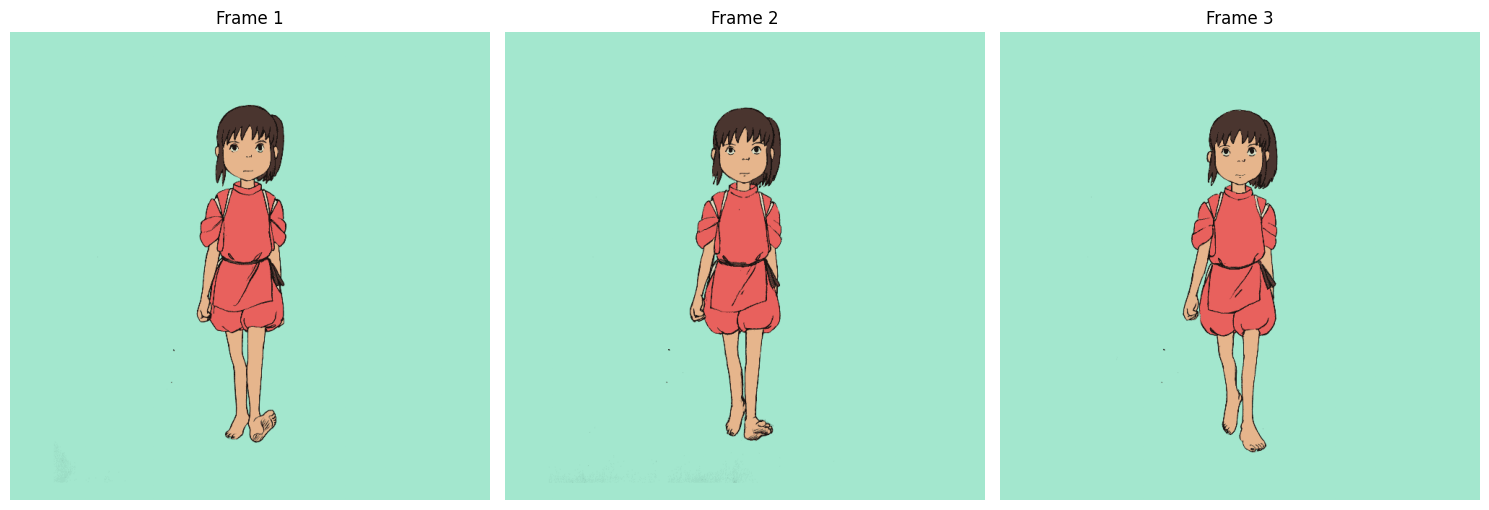

In [48]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import os

# Directory for saving the frames
save_directory = "/content/drive/MyDrive/AAAI/original_girl"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Load the GIF
input_gif_path = "/content/drive/MyDrive/AAAI/girl.gif"
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]
print(len(frames))
# Save frames
saved_paths = []
for idx, frame in enumerate(frames):
    save_path = os.path.join(save_directory, f"frame_{idx + 1}.png")
    frame.save(save_path)
    saved_paths.append(save_path)

# Display the first three saved frames
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    if i < len(saved_paths):
        ax.imshow(plt.imread(saved_paths[i]))
        ax.set_title(f"Frame {i + 1}")
        ax.axis('off')
plt.tight_layout()
plt.show()

## **Create original outline**

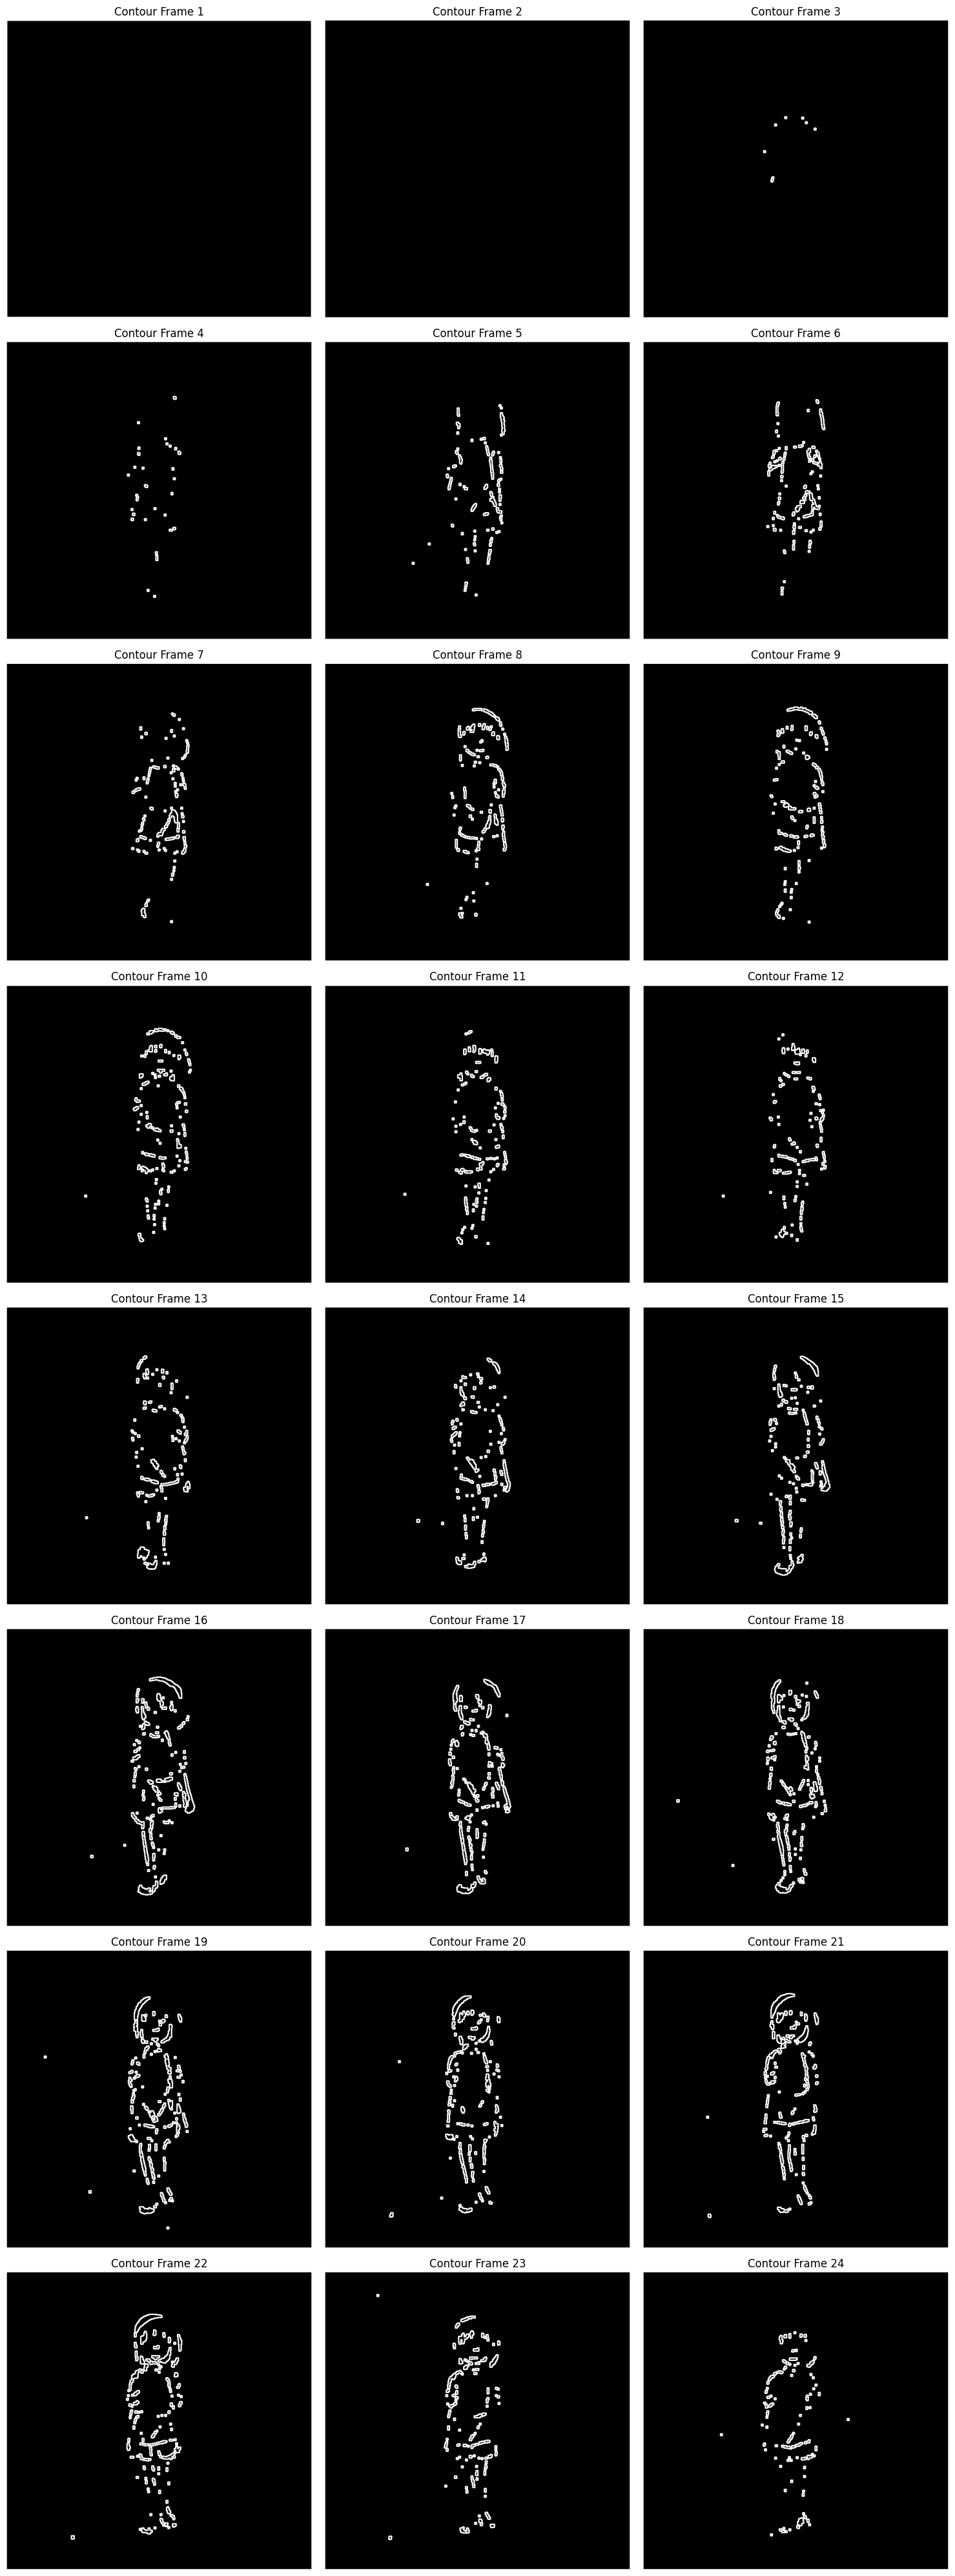

In [50]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Path to the GIF in Google Drive
#input_gif_path = "/content/drive/MyDrive/AAAI/original_girl"
input_gif_path = "/content/drive/MyDrive/AAAI/girl.gif"

# Load the GIF
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process all frames in the GIF
all_foreground_frames = []
len(frames);
for frame in frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

    all_foreground_frames.append(foreground)

# Extract contours of the foreground objects for all frames
kernel = np.ones((3,3), np.uint8)  # Kernel for dilation
all_contour_frames = []

for frame in all_foreground_frames:
    # If the frame is already grayscale, skip the conversion
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        gray_frame = frame
    else:
        # Convert RGB frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

    # Dilation to enhance the thickness of the contours
    dilated = cv2.dilate(thresh, kernel, iterations=2)

    # Find contours on the dilated image
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty black image to draw contours on
    contour_image = np.zeros_like(gray_frame)

    # Draw contours with increased thickness
    cv2.drawContours(contour_image, contours, -1, 255, 2)  # Drawing in white color with thickness=2

    # Draw a rectangle around the entire image
    h, w = contour_image.shape
    cv2.rectangle(contour_image, (0, 0), (w-1, h-1), 255, 1)

    all_contour_frames.append(contour_image)

# Display all the contour frames
num_frames = len(all_contour_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, contour_frame in enumerate(all_contour_frames):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(contour_frame, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()



Test2

# **For each detected contour, we will compute the centroid (or center) of the contour.**
We will then compute the distance of every point on the contour from this centroid.
If all points on the contour lie within a specified radius (small circle) of the centroid, we will classify this contour as noise and remove it.

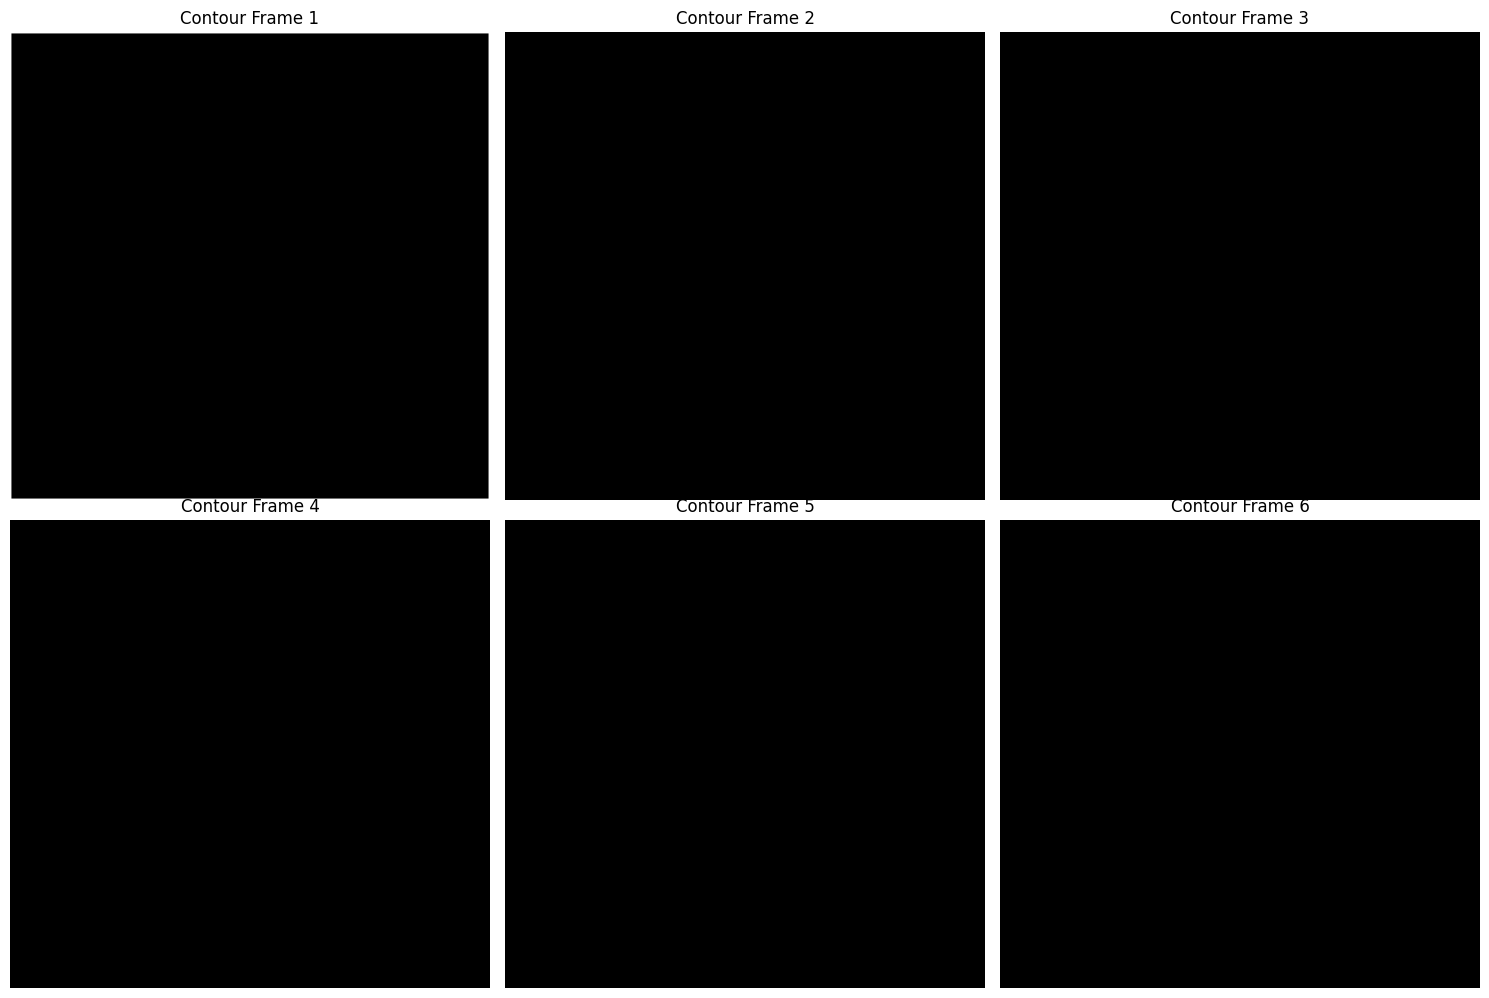

In [51]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Path to the GIF
input_gif_path = "/content/drive/MyDrive/AAAI/girl.gif"  # Change this to the path of your GIF

# Load the GIF
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process all frames in the GIF
all_foreground_frames = []
for frame in frames:
    frame_np = np.array(frame)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)
    fgmask = fgbg.apply(frame_np)
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)
    all_foreground_frames.append(foreground)

# Kernel for dilation
kernel = np.ones((3,3), np.uint8)

# Extract and refine contours of the foreground objects for all frames
radius_threshold = 50
filtered_contour_frames = []
for frame in all_foreground_frames:
    if frame.shape[-1] == 3:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    else:
        gray_frame = frame
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(thresh, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(gray_frame)
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] == 0:
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid = np.array([cX, cY])
        distances = np.linalg.norm(contour - centroid, axis=2)
        if np.all(distances < radius_threshold):
            continue
        cv2.drawContours(contour_image, [contour], -1, 255, 2)
    filtered_contour_frames.append(contour_image)

# Display the first 6 filtered contour frames in a 2x3 grid
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, contour_frame in enumerate(filtered_contour_frames[:6]):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(contour_frame, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 1}")
plt.tight_layout()
plt.show()


In [6]:
from PIL import Image

# Convert the processed frames back to PIL images
filtered_pil_frames = [Image.fromarray(frame) for frame in filtered_contour_frames]

# Save as a new GIF
output_gif_path = "/content/drive/MyDrive/AAAI/girl_no_noise.gif"  # Change this to your desired output path
filtered_pil_frames[0].save(output_gif_path, save_all=True, append_images=filtered_pil_frames[1:], loop=0, duration=img.info['duration'])

print(f"New GIF saved at: {output_gif_path}")


New GIF saved at: /content/drive/MyDrive/AAAI/girl_no_noise.gif


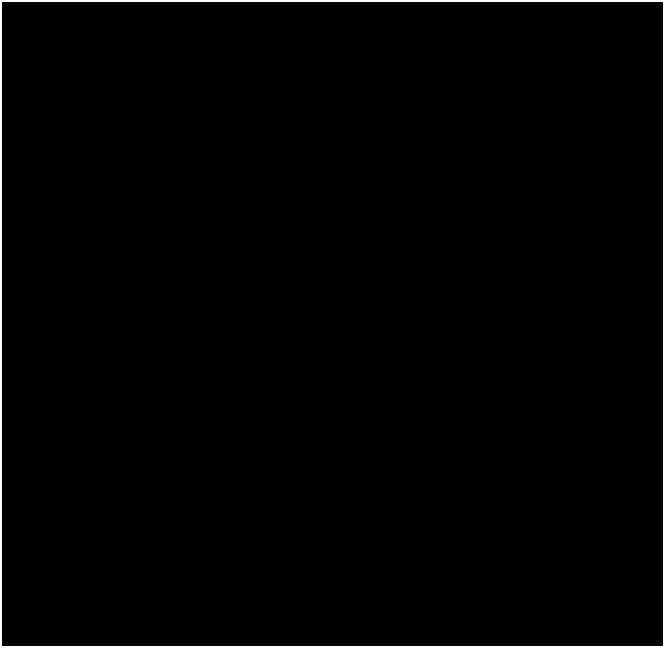

In [7]:
from IPython.display import display, Image

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/girl_no_noise.gif"

# Display the GIF
with open(input_gif_path, "rb") as f:
    display(Image(data=f.read(), format='png'))


In [8]:
import imageio
from sklearn.cluster import KMeans
from skimage.transform import resize
import numpy as np

# Load the GIF using ImageIO's get_reader
gif_path = "/content/drive/MyDrive/AAAI/girl.gif"
reader = imageio.get_reader(gif_path)

# Extract the duration of the GIF frames and the frames themselves
durations = []
frames = []
for i, frame in enumerate(reader):
    durations.append(reader.get_meta_data(i)['duration'])
    frames.append(np.array(frame))

# Segment the frames
segmented_frames = []
for img in frames:
    # Convert the image into a list of pixels
    pixels = img.reshape(-1, 4)

    # Cluster the pixels using KMeans
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
    kmeans.fit(pixels)

    # Replace each pixel with its center
    segmented_pixels = np.array([list(kmeans.cluster_centers_[label]) for label in kmeans.labels_])

    # Reshape the result pixels into the original image shape
    segmented_img = segmented_pixels.reshape(img.shape)
    segmented_frames.append(segmented_img.astype(np.uint8))

# Get the shape of the first frame
first_frame_shape = segmented_frames[0].shape

# Resize all frames to match the shape of the first frame
segmented_frames_resized = [resize(frame, first_frame_shape) for frame in segmented_frames]

# Convert values to uint8 format for saving as GIF
segmented_frames_resized = [(frame * 255).astype(np.uint8) for frame in segmented_frames_resized]

# Save the resized frames as a new GIF
output_gif_path = "/content/drive/MyDrive/AAAI/segmentedG_resized2.gif"
imageio.mimsave(output_gif_path, segmented_frames_resized, duration=durations)



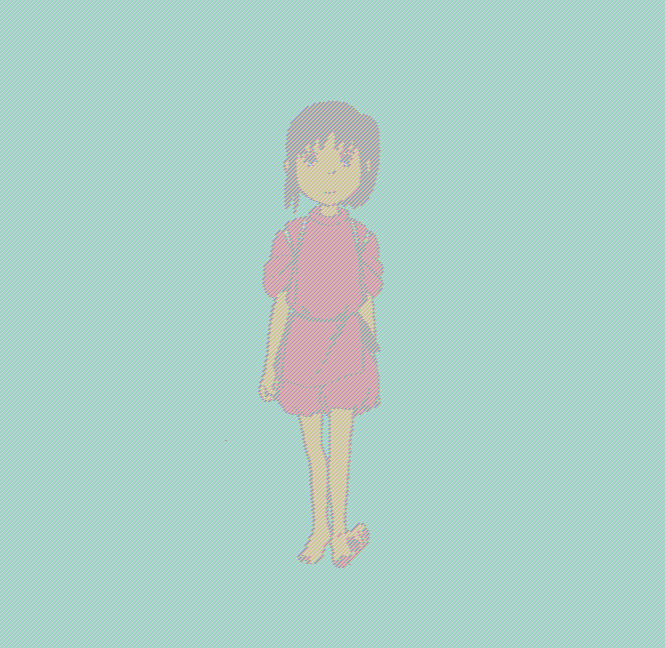

In [9]:
from IPython.display import display, Image

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/segmentedG_resized2.gif"

# Display the GIF
with open(input_gif_path, "rb") as f:
    display(Image(data=f.read(), format='png'))

In [10]:
import imageio
import numpy as np
from sklearn.cluster import KMeans
from skimage.transform import resize

# Function to segment an image based on KMeans clustering
def segment_image(img, n_clusters):
    # Flatten the image
    pixels = img.reshape(-1, 4)

    # Remove alpha if it's 255 everywhere
    if np.all(pixels[:, 3] == 255):
        pixels = pixels[:, :3]

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(pixels)
    segmented_pixels = kmeans.cluster_centers_[kmeans.labels_]

    # Add back the alpha channel if it was removed earlier
    if segmented_pixels.shape[1] != 4:
        alpha_channel = np.full((segmented_pixels.shape[0], 1), 255)
        segmented_pixels = np.concatenate([segmented_pixels, alpha_channel], axis=1)

    # Convert back to the original shape
    segmented_img = segmented_pixels.reshape(img.shape)
    return segmented_img.astype(np.uint8)

# Read the GIF and its metadata
gif_path = "/content/drive/MyDrive/AAAI/girl.gif"
reader = imageio.get_reader(gif_path)
durations = [reader.get_meta_data(i)['duration'] for i in range(reader.get_length())]

# Process each frame
segmented_frames = []
first_frame_shape = np.array(reader.get_data(0)).shape

for img in reader:
    img_array = np.array(img)
    segmented_img = segment_image(img_array, 4)  # Using 4 clusters

    # Resize the segmented image to match the first frame shape
    resized_segmented_img = resize(segmented_img, (first_frame_shape[0], first_frame_shape[1]), preserve_range=True).astype(np.uint8)

    segmented_frames.append(resized_segmented_img)

# Save the segmented frames as a new GIF
output_gif_path = "/content/drive/MyDrive/AAAI/segment_gir.gif"
imageio.mimsave(output_gif_path, segmented_frames, duration=durations)



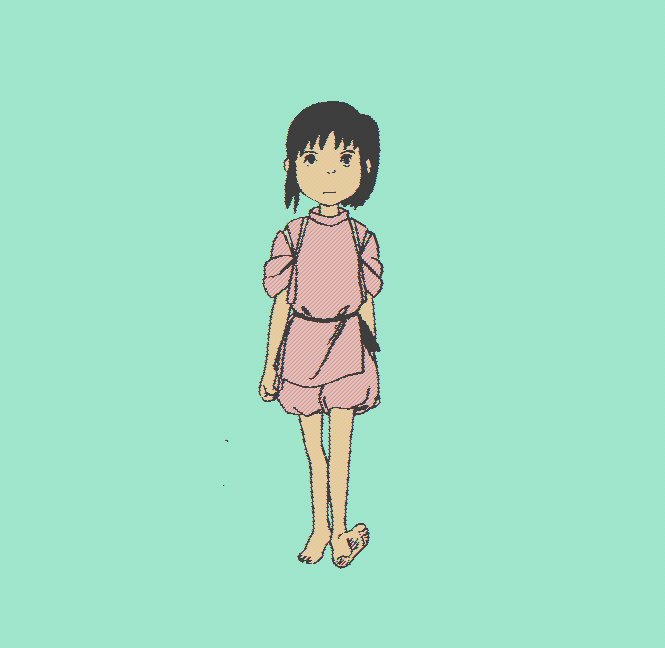

In [11]:
from IPython.display import display, Image

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/segment_gir.gif"

# Display the GIF
with open(input_gif_path, "rb") as f:
    display(Image(data=f.read(), format='png'))

## **Show only the shape/outline**

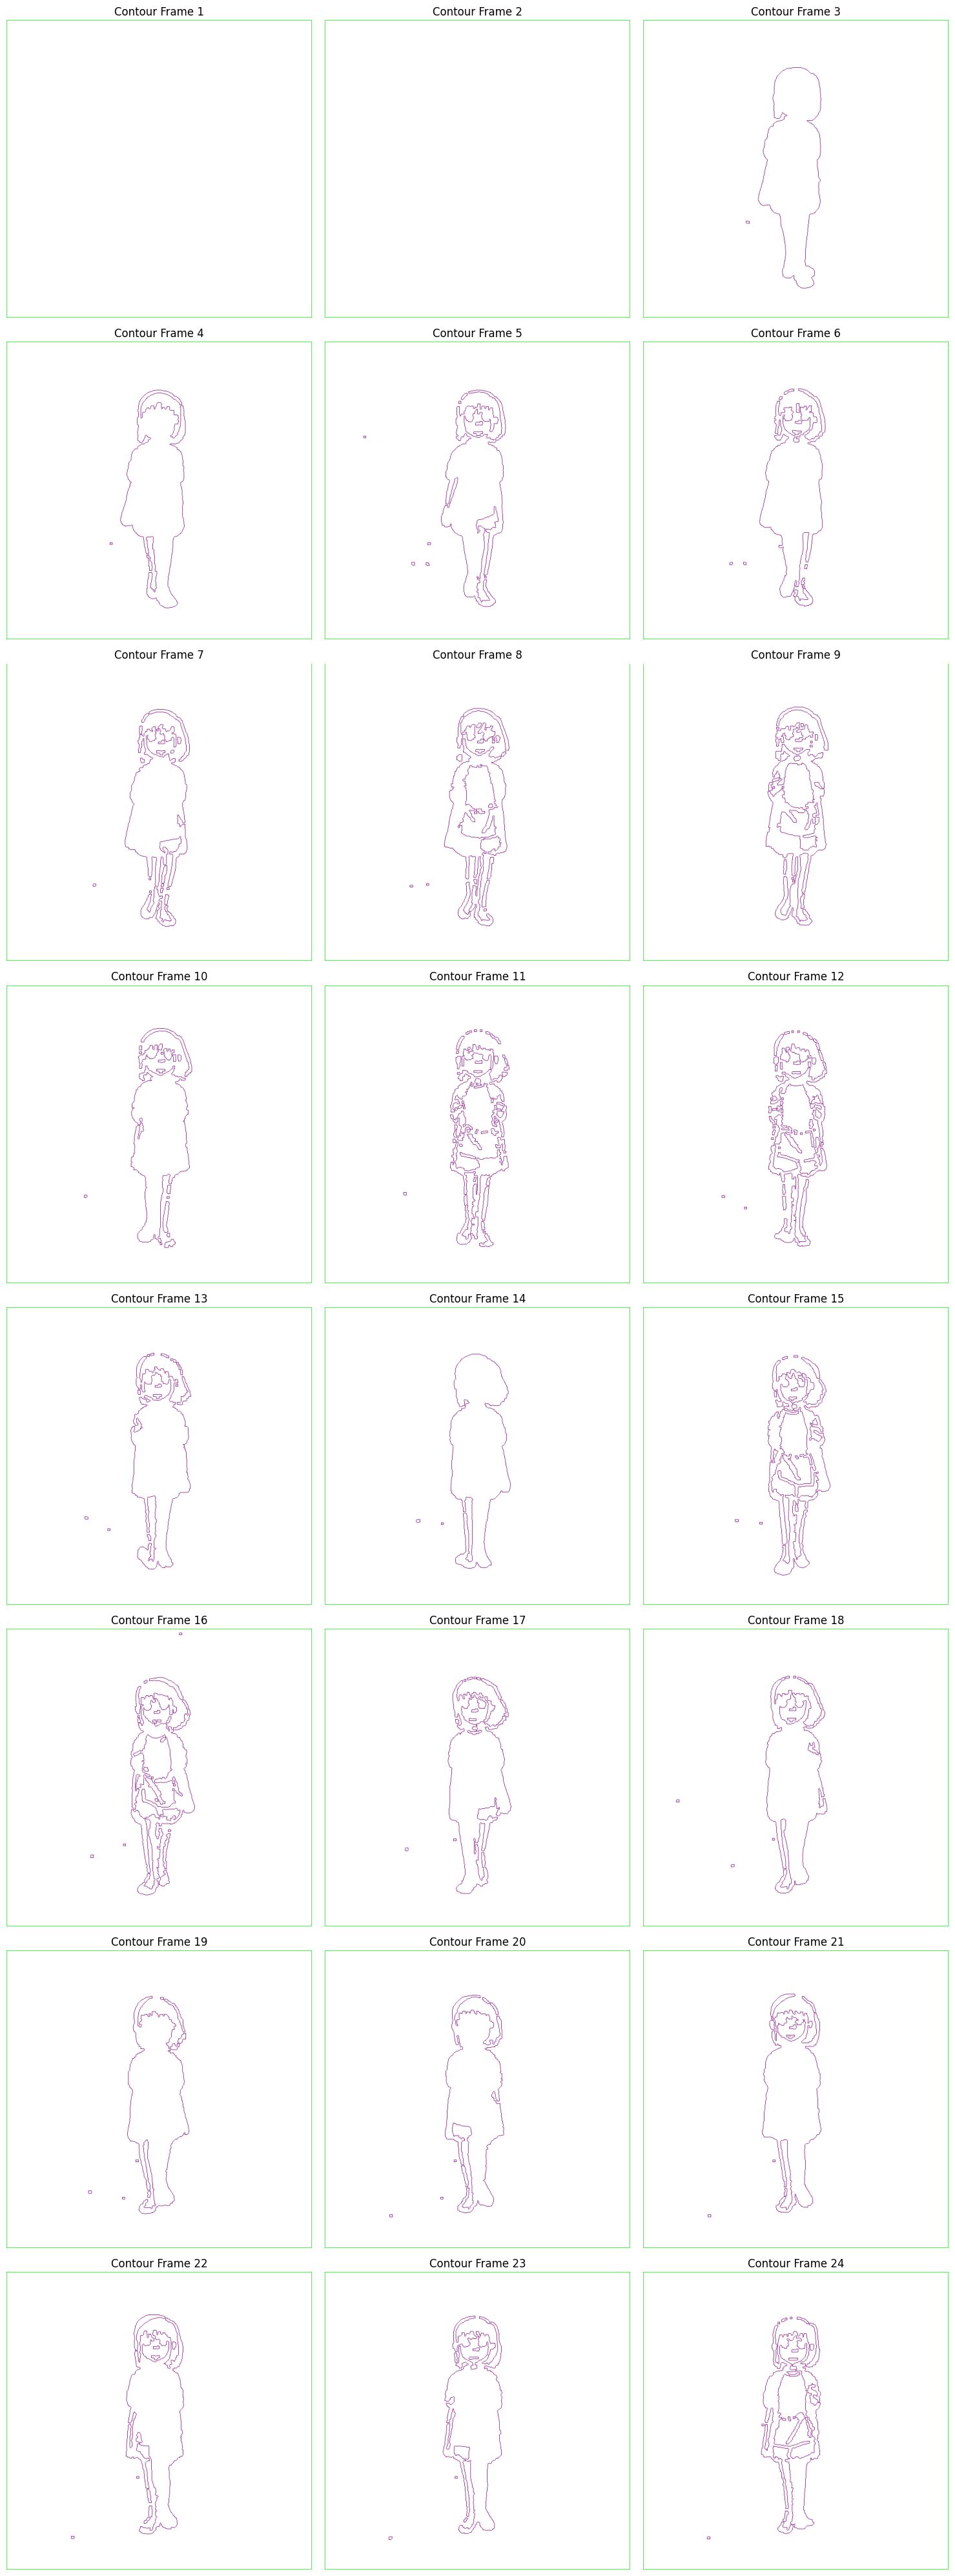

In [20]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Path to the GIF in Google Drive
#input_gif_path = "/content/drive/MyDrive/AAAI/girl.gif"
input_gif_path = "/content/drive/MyDrive/AAAI/segment_gir.gif"


# Load the GIF
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process all frames in the GIF
all_foreground_frames = []

for frame in frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

    all_foreground_frames.append(foreground)

# Extract contours of the foreground objects for all frames
kernel = np.ones((3,3), np.uint8)  # Kernel for dilation
all_contour_frames = []

for frame in all_foreground_frames:
    # Convert RGB frame to grayscale, if not already grayscale
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        gray_frame = frame
    else:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

    # Dilation to enhance the thickness of the contours
    dilated = cv2.dilate(thresh, kernel, iterations=2)

    # Find contours on the dilated image
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty white image to draw contours on
    contour_image = 255 * np.ones_like(frame)

    # If the contour image is grayscale, convert it to RGB
    if len(contour_image.shape) == 2:
        contour_image = cv2.cvtColor(contour_image, cv2.COLOR_GRAY2RGB)

    # Draw contours with increased thickness in green color
    #cv2.drawContours(contour_image, contours, -1, [0, 255, 0], 2)  # Green color with thickness=2
    # Draw contours with increased thickness in purple color
    cv2.drawContours(contour_image, contours, -1, [128, 0, 128], 1)  # Purple color with thickness=1


    # Draw a green rectangle around the entire image
    h, w, _ = contour_image.shape
    cv2.rectangle(contour_image, (0, 0), (w-1, h-1), [0, 255, 0], 1)

    all_contour_frames.append(contour_image)

# Display all the contour frames
num_frames = len(all_contour_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, contour_frame in enumerate(all_contour_frames):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(contour_frame)
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()



## **Save the frames** - UNCOMMENT TO SAVE

In [28]:
# Define the output directory
output_directory = "/content/drive/MyDrive/AAAI/contour_frames_girl3"

# Create the directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Save each contour frame
for idx, contour_frame in enumerate(all_contour_frames):
    filename = f"contour_frame_{idx + 1}.png"
    filepath = os.path.join(output_directory, filename)

    # UNCOMMENT TO REWRITE
    cv2.imwrite(filepath, contour_frame)

print(f"Saved {len(all_contour_frames)} contour frames to {output_directory}")


Saved 24 contour frames to /content/drive/MyDrive/AAAI/contour_frames_girl3


## **Merge Frames into GIF** - UNCOMMENT TO SAVE

In [29]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display

# Convert contour frames to PIL images
pil_images = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in all_contour_frames]

# Save frames as a GIF
#output_gif_path = "/content/drive/MyDrive/AAAI/green_contours.gif"
output_gif_path = "/content/drive/MyDrive/AAAI/girl_contours3.gif"

#UNCOMMENT this to rewrite
pil_images[0].save(output_gif_path, save_all=True, append_images=pil_images[1:], loop=0, duration=img.info['duration'])


## **Countours GIF**

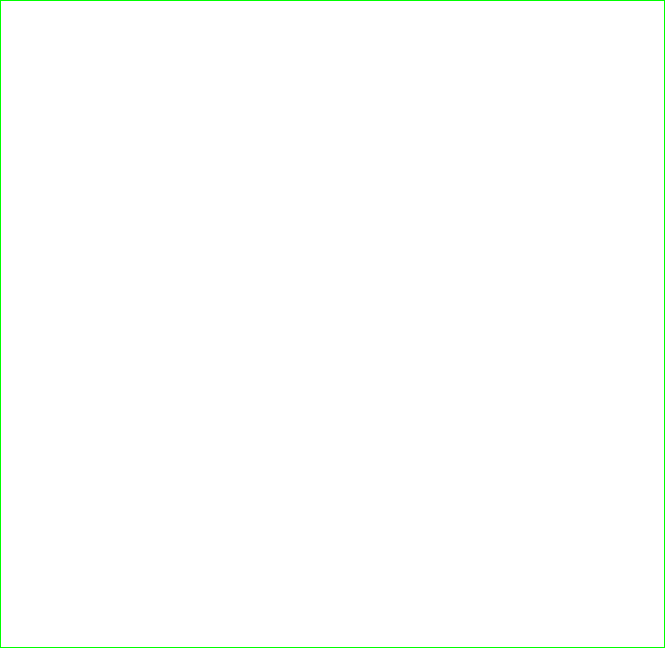

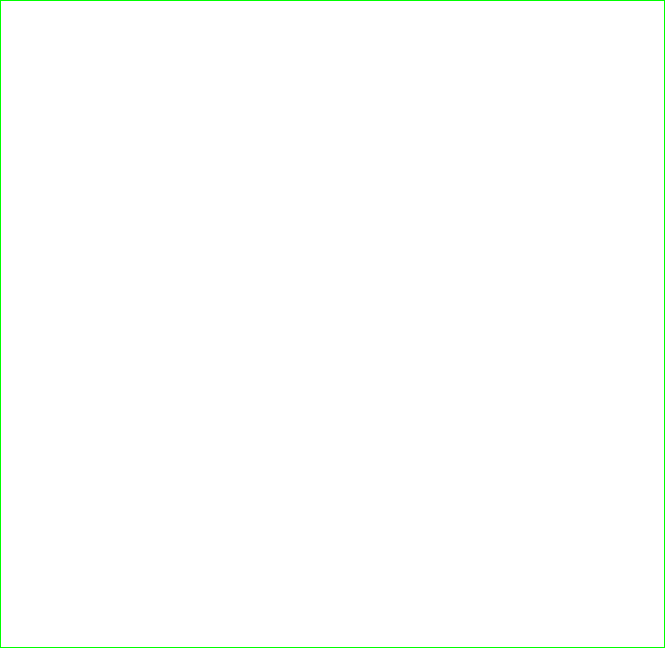

In [30]:
from IPython.display import display, Image

# Path to the GIF in Google Drive
#path = "/content/drive/MyDrive/AAAI/green_contours.gif"
path = "/content/drive/MyDrive/AAAI/girl_contours.gif"

# Display the GIF
with open(path, "rb") as f:
    display(Image(data=f.read(), format='png'))

path2 = "/content/drive/MyDrive/AAAI/girl_contours3.gif"

# Display the GIF
with open(path2, "rb") as f:
    display(Image(data=f.read(), format='png'))

# **Add Axis**

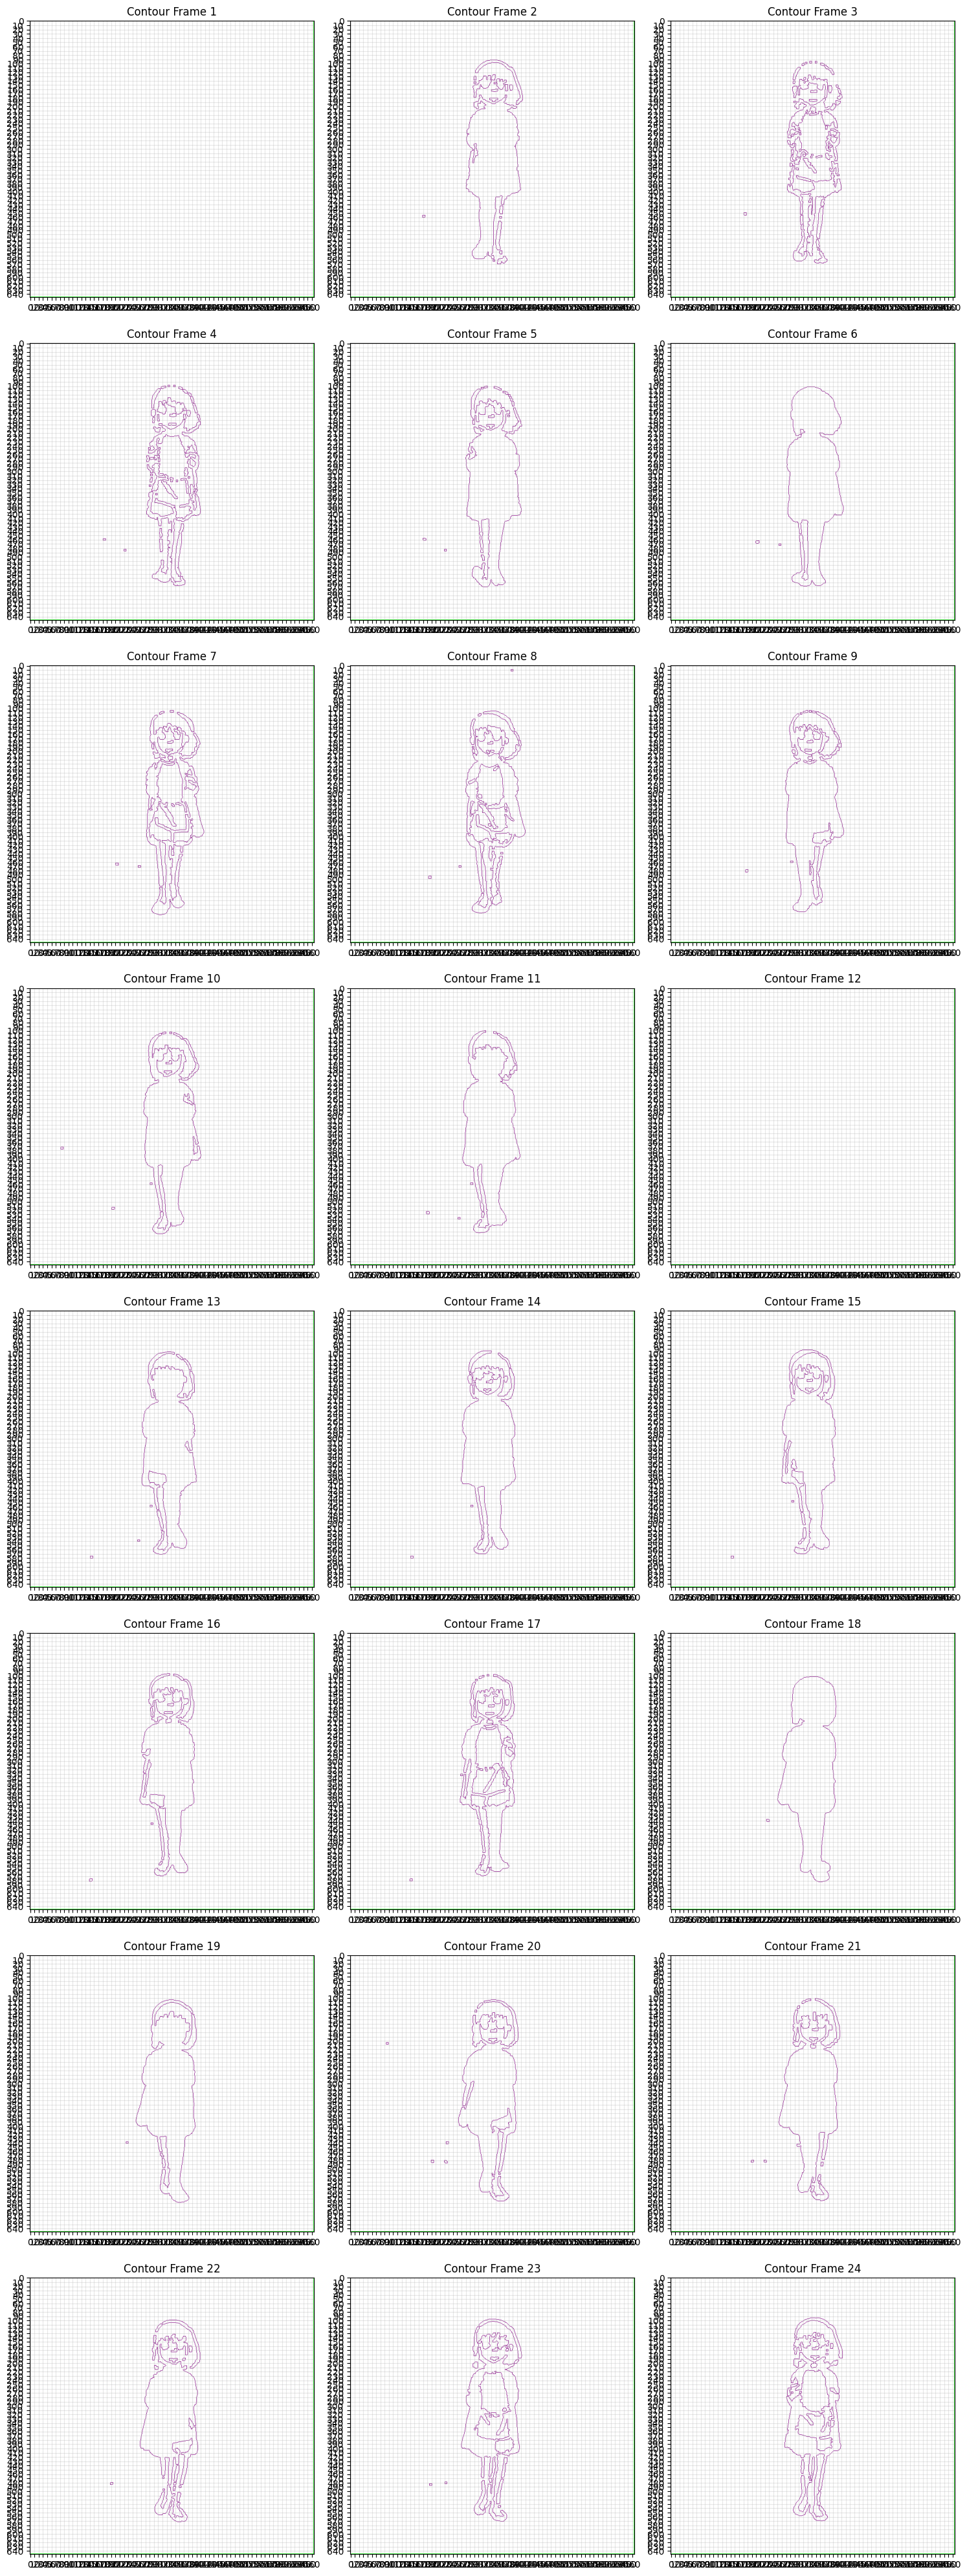

In [31]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Define the path to the previously saved contour frames
contour_frames_folder = "/content/drive/MyDrive/AAAI/contour_frames_girl3"

# Load the saved contour frames
saved_contour_frames = []
frame_files = sorted(os.listdir(contour_frames_folder))
for frame_file in frame_files:
    frame_path = os.path.join(contour_frames_folder, frame_file)
    frame = cv2.imread(frame_path)
    if frame is not None:
        saved_contour_frames.append(frame)

# Display the frames with the axes
num_frames = len(saved_contour_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)

fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, overlay_frame in enumerate(saved_contour_frames):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(cv2.cvtColor(overlay_frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    ax[row, col].set_xticks(np.arange(0, overlay_frame.shape[1], 10))
    ax[row, col].set_yticks(np.arange(0, overlay_frame.shape[0], 10))
    ax[row, col].grid(which='both', alpha=0.3)
    ax[row, col].set_title(f"Contour Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()



# **Midpoints array**

In [17]:
#import cv2
#import numpy as np
##import os
#import matplotlib.pyplot as plt

# Define the path to the previously saved contour frames
#contour_frames_folder = "/content/drive/MyDrive/AAAI/contour_frames_purple"

# Load the saved contour frames
##saved_contour_frames = []
#frame_files = sorted(os.listdir(contour_frames_folder))
#for frame_file in frame_files:
##    frame_path = os.path.join(contour_frames_folder, frame_file)
#    frame = cv2.imread(frame_path)
#    if frame is not None:
#        saved_contour_frames.append(frame)

# Directory for saving the frames with grids
##grid_frames_folder = "/content/drive/MyDrive/AAAI/grid_frames"
#os.makedirs(grid_frames_folder, exist_ok=True)

# Grid interval
#interval = 10
#purple_color = [255, 0, 255]  # BGR format

#all_crossings = []

#for idx, frame in enumerate(saved_contour_frames):
    # Draw grid on the frame
#    for x in range(0, frame.shape[1], interval):
#        cv2.line(frame, (x, 0), (x, frame.shape[0]), (0, 0, 0), 1)
#    for y in range(0, frame.shape[0], interval):
#        cv2.line(frame, (0, y), (frame.shape[1], y), (0, 0, 0), 1)

    # Save the frame with the grid
#    frame_path = os.path.join(grid_frames_folder, f"grid_frame_{idx + 1}.png")
#    cv2.imwrite(frame_path, frame)

    # Detect crossings of purple and grid
#    crossings = []
#    for x in range(0, frame.shape[1], interval):
#        for y in range(0, frame.shape[0], interval):
#            if np.array_equal(frame[y, x], purple_color):
#                crossings.append((x, y))
#    all_crossings.append(crossings)

# Save crossings to a txt file
##crossings_file = "/content/drive/MyDrive/AAAI/crossings.txt"
#with open(crossings_file, 'w') as f:
#    for idx, crossings in enumerate(all_crossings):
#        #f.write(f"Frame {idx + 1}:\n") #UNCOMMENT TO SAVE
#        for crossing in crossings:
#            #f.write(f"{crossing}\n") #UNCOMMENT TO SAVE
#        #UNf.write("\n")
#
#print(f"Saved all crossings to {crossings_file}")

## **Midpoints Array**

In [36]:
import cv2
import numpy as np
import os

# Define the path to the previously saved contour frames
contour_frames_folder = "/content/drive/MyDrive/AAAI/contour_frames_girl3"

# Directory for saving the coordinate files
coords_folder = "/content/drive/MyDrive/AAAI/coords_g_segmented"
os.makedirs(coords_folder, exist_ok=True)

# List all the frame files
frame_files = sorted(os.listdir(contour_frames_folder))

for idx, frame_file in enumerate(frame_files):
    #print("in a loop")
    # Load the frame
    frame_path = os.path.join(contour_frames_folder, frame_file)
    frame = cv2.imread(frame_path)

    coords = []

    # Convert frame to HSV for better color segmentation
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define a range for purple color
    lower_purple = np.array([130, 50, 50])
    upper_purple = np.array([160, 255, 255])

    # Create a mask for purple color
    mask = cv2.inRange(hsv, lower_purple, upper_purple)

    y_indices, x_indices = np.where(mask == 255)
    coords = list(zip(x_indices, y_indices))

    # Define the path for the coordinates file
    coords_path = os.path.join(coords_folder, f"frame_{idx + 1}_coords.txt")

    # Save the coordinates to a separate txt file for the frame
    if coords:
        with open(coords_path, 'w') as f:
            for coord in coords:
                f.write(f"{coord}\n")

    print(f"Saved coordinates for frame {idx + 1} to {coords_path}")


in a loop
Saved coordinates for frame 1 to /content/drive/MyDrive/AAAI/coords_g_segmented/frame_1_coords.txt
in a loop
Saved coordinates for frame 2 to /content/drive/MyDrive/AAAI/coords_g_segmented/frame_2_coords.txt
in a loop
Saved coordinates for frame 3 to /content/drive/MyDrive/AAAI/coords_g_segmented/frame_3_coords.txt
in a loop
Saved coordinates for frame 4 to /content/drive/MyDrive/AAAI/coords_g_segmented/frame_4_coords.txt
in a loop
Saved coordinates for frame 5 to /content/drive/MyDrive/AAAI/coords_g_segmented/frame_5_coords.txt
in a loop
Saved coordinates for frame 6 to /content/drive/MyDrive/AAAI/coords_g_segmented/frame_6_coords.txt
in a loop
Saved coordinates for frame 7 to /content/drive/MyDrive/AAAI/coords_g_segmented/frame_7_coords.txt
in a loop
Saved coordinates for frame 8 to /content/drive/MyDrive/AAAI/coords_g_segmented/frame_8_coords.txt
in a loop
Saved coordinates for frame 9 to /content/drive/MyDrive/AAAI/coords_g_segmented/frame_9_coords.txt
in a loop
Saved coo

In [35]:
#import cv2
#import numpy as np
#import os

# Define the path to the previously saved contour frames
#contour_frames_folder = "/content/drive/MyDrive/AAAI/contour_frames_girl3"

# Directory for saving the coordinate files
#coords_folder = "/content/drive/MyDrive/AAAI/coords_g_segmented"
#os.makedirs(coords_folder, exist_ok=True)

# Define the purple color in BGR format
#target_color = np.array([255, 0, 255])
#tolerance = 40

# List all the frame files
#frame_files = sorted(os.listdir(contour_frames_folder))

#for idx, frame_file in enumerate(frame_files):
#    print("in a loop")
#    # Load the frame
#    frame_path = os.path.join(contour_frames_folder, frame_file)
#    frame = cv2.imread(frame_path)

#    coords = []

#    # Convert frame to HSV for better color segmentation
#    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

#    # Define a range for purple color
#    lower_purple = np.array([130, 50, 50])
#    upper_purple = np.array([160, 255, 255])

    # Create a mask for purple color
#    mask = cv2.inRange(hsv, lower_purple, upper_purple)

#    y_indices, x_indices = np.where(mask == 255)
#    coords = list(zip(x_indices, y_indices))

    # Save the coordinates to a separate txt file for the frame
#    if coords:
#        coords_path = os.path.join(coords_folder, f"frame_{idx + 1}_coords.txt")
#        with open(coords_path, 'w') as f: #UNCOMMENT TO SAVE
#            for coord in coords: #UNCOMMENT TO SAVE
#                f.write(f"{coord}\n") #UNCOMMENT TO SAVE
#
#    print(f"Saved coordinates for frame {idx + 1} to {coords_path}")

in a loop


NameError: ignored

## **Skeleton Draft**

In [37]:
import os
import cv2
from collections import defaultdict
import numpy as np

# Directories
#oord_directory = "/content/drive/MyDrive/AAAI/coords"
coord_directory = "/content/drive/MyDrive/AAAI/coords_g_segmented"
#contour_frames_folder = "/content/drive/MyDrive/AAAI/contour_frames_purple"
contour_frames_folder = "/content/drive/MyDrive/AAAI/contour_frames_girl3"
output_directory = "/content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_betweenG"
os.makedirs(output_directory, exist_ok=True)

# List all the .txt files in the coord directory
txt_files = [f for f in sorted(os.listdir(coord_directory)) if f.endswith(".txt")]

for idx, txt_file in enumerate(txt_files):
    # Read the .txt file and convert to list of coordinates
    with open(os.path.join(coord_directory, txt_file), 'r') as file:
        coords = [tuple(map(int, line.strip().replace('(', '').replace(')', '').split(','))) for line in file.readlines()]

    # Create dictionaries to store x and y coordinates
    y_to_xs = defaultdict(list)
    x_to_ys = defaultdict(list)
    for x, y in coords:
        y_to_xs[y].append(x)
        x_to_ys[x].append(y)

    # Load the corresponding purple contour frame
    frame_path = os.path.join(contour_frames_folder, f"contour_frame_{idx + 1}.png")
    frame = cv2.imread(frame_path)

    # Draw midpoints for y_to_xs
    for y, xs in y_to_xs.items():
        if len(xs) >= 2:
            x_mid = (min(xs) + max(xs)) // 2
            cv2.circle(frame, (x_mid, y), 2, (0, 0, 255), -1)  # Red dot

    # Draw midpoints for x_to_ys
    for x, ys in x_to_ys.items():
        if len(ys) >= 2:
            y_mid = (min(ys) + max(ys)) // 2
            cv2.circle(frame, (x, y_mid), 2, (0, 0, 255), -1)  # Red dot

    # Save the modified frame
    output_path = os.path.join(output_directory, f"output_frame_{idx + 1}.png")
    cv2.imwrite(output_path, frame)

    print(f"Saved frame {idx + 1} with midpoints to {output_path}")




Saved frame 1 with midpoints to /content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_betweenG/output_frame_1.png
Saved frame 2 with midpoints to /content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_betweenG/output_frame_2.png
Saved frame 3 with midpoints to /content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_betweenG/output_frame_3.png
Saved frame 4 with midpoints to /content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_betweenG/output_frame_4.png
Saved frame 5 with midpoints to /content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_betweenG/output_frame_5.png
Saved frame 6 with midpoints to /content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_betweenG/output_frame_6.png
Saved frame 7 with midpoints to /content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_betweenG/output_frame_7.png
Saved frame 8 with midpoints to /content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_betweenG/output_frame_8.png
Saved frame 9 with midpoints to /content

# **Display Skeleton Draft**

In [38]:
from PIL import Image
import os

# Directories
output_directory = "/content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_betweenG"
#output_directory = "/content/drive/MyDrive/AAAI/output_frames_with_midpoints_no_between"
output_gif_path = "/content/drive/MyDrive/AAAI/midpoints_contoursG.gif"

# Load the modified frames
frames = [Image.open(os.path.join(output_directory, f"output_frame_{idx + 1}.png")) for idx in range(len(txt_files))]

# Save the frames as a GIF
frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], loop=0, duration=100)

print(f"Saved GIF to {output_gif_path}")


Saved GIF to /content/drive/MyDrive/AAAI/midpoints_contoursG.gif


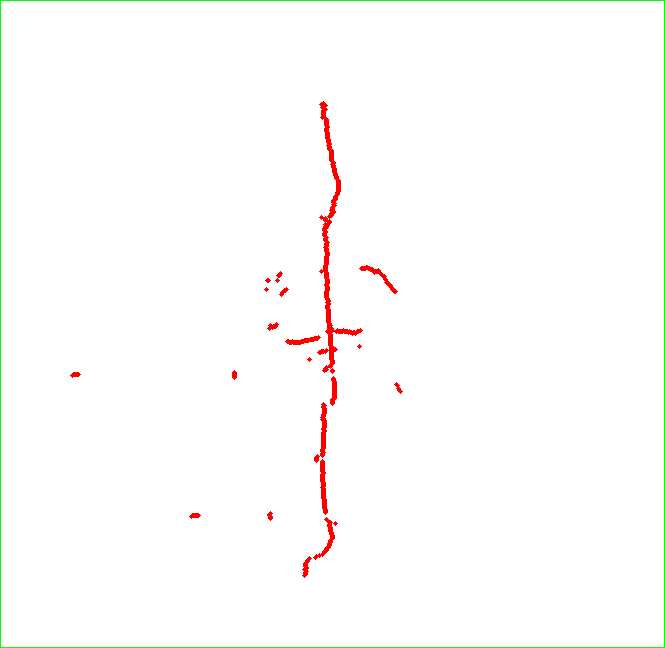

In [39]:
from IPython.display import display, Image

# Path to the GIF in Google Drive
#input_gif_path = "/content/drive/MyDrive/AAAI/midpoints_contours.gif"
input_gif_path = "/content/drive/MyDrive/AAAI/midpoints_contoursG.gif"
# Display the GIF
with open(input_gif_path, "rb") as f:
    display(Image(data=f.read(), format='png'))


# **Average Outline**

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Directory
output_directory = "/content/drive/MyDrive/AAAI/contour_frames_purple"

# Load the modified frames and filter out any None frames
frames = [cv2.imread(os.path.join(output_directory, f"output_frame_{idx + 1}.png"), cv2.IMREAD_GRAYSCALE) for idx in range(len(txt_files))]
print(len(frames))
frames = [frame for frame in frames if frame is not None]
print(len(frames))

# Initialization
accumulator = np.zeros_like(frames[0], dtype=np.float32)
print(len(frames))

# Accumulation
for frame in frames:
    accumulator += frame

# Normalization
average_frame = (accumulator / len(frames)).astype(np.uint8)

# Thresholding to get the most frequent midpoints
_, average_outline = cv2.threshold(average_frame, 127, 255, cv2.THRESH_BINARY)

# Display
plt.imshow(average_outline, cmap='gray')
plt.axis('off')
plt.title("Average Outline")
plt.show()

# Save
output_path = "/content/drive/MyDrive/AAAI/average_outline.png"
cv2.imwrite(output_path, average_outline)


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Define the path to the previously saved contour frames
contour_frames_folder = "/content/drive/MyDrive/AAAI/contour_frames_good"

# Load the saved contour frames
saved_contour_frames = []
frame_files = sorted(os.listdir(contour_frames_folder))
for frame_file in frame_files:
    frame_path = os.path.join(contour_frames_folder, frame_file)
    frame = cv2.imread(frame_path)
    if frame is not None:
        saved_contour_frames.append(frame)

# Find and paint midpoints in red
midpoint_frames = []
for frame in saved_contour_frames:
    # Convert RGB frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding to get the contour in binary form
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the frame to mark midpoints
    midpoint_frame = frame.copy()

    for contour in contours:
        # Extract x and y coordinates of the contour points
        x_coords = contour[:, 0, 0]
        y_coords = contour[:, 0, 1]

        # For each unique x, find the range of y values and compute the midpoint
        for x in np.unique(x_coords):
            corresponding_ys = y_coords[x_coords == x]
            y_min, y_max = np.min(corresponding_ys), np.max(corresponding_ys)
            y_mid = (y_min + y_max) // 2
            midpoint_frame[y_mid, x] = [0, 0, 255]  # Red color

        # For each unique y, find the range of x values and compute the midpoint
        for y in np.unique(y_coords):
            corresponding_xs = x_coords[y_coords == y]
            x_min, x_max = np.min(corresponding_xs), np.max(corresponding_xs)
            x_mid = (x_min + x_max) // 2
            midpoint_frame[y, x_mid] = [0, 0, 255]  # Red color

    midpoint_frames.append(midpoint_frame)

# Display the frames with midpoints
num_frames = len(midpoint_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, midpoint_frame in enumerate(midpoint_frames):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(cv2.cvtColor(midpoint_frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    ax[row, col].axis('on')
    ax[row, col].set_xticks(np.arange(0, midpoint_frame.shape[1], 10))
    ax[row, col].set_yticks(np.arange(0, midpoint_frame.shape[0], 10))
    ax[row, col].grid(which='both', alpha=0.3)
    ax[row, col].set_title(f"Midpoint Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
# Function to extract skeleton from a binary image
def extract_skeleton(binary_img):
    # Convert to uint8 for processing
    binary_img = binary_img.astype(np.uint8)

    # Use the OpenCV's ximgproc module to extract the skeleton
    skeleton = cv2.ximgproc.thinning(binary_img)
    return skeleton

# Extract skeletons and overlay with green contours
all_overlay_frames = []

for contour_frame in saved_contour_frames:
    # Convert green contours to grayscale for skeleton extraction
    gray_contour_frame = cv2.cvtColor(contour_frame, cv2.COLOR_BGR2GRAY)

    # Threshold to get binary image
    _, binary = cv2.threshold(gray_contour_frame, 1, 255, cv2.THRESH_BINARY)

    # Extract the skeleton from the binary contour image
    skeleton = extract_skeleton(binary)

    # Convert the skeleton to red
    red_skeleton = np.zeros_like(contour_frame)
    red_skeleton[skeleton == 255] = [0, 0, 255]

    # Overlay the green contour and red skeleton
    overlay = cv2.addWeighted(contour_frame, 1, red_skeleton, 1, 0)
    all_overlay_frames.append(overlay)

# Display the overlay frames
num_frames = len(all_overlay_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, overlay_frame in enumerate(all_overlay_frames):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(cv2.cvtColor(overlay_frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Overlay Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Define the directory where green contour frames are saved
input_directory = "/content/drive/MyDrive/AAAI/contour_frames_good"

# Load the saved green contour frames
saved_contour_frames = []
filelist = sorted(os.listdir(input_directory), key=lambda x: int(x.split('_')[-1].split('.')[0]))  # Sort files by frame number
for filename in filelist:
    filepath = os.path.join(input_directory, filename)
    image = cv2.imread(filepath)
    saved_contour_frames.append(image)

# Overlay the loaded green contours with red skeletons
all_overlay_frames = []
for contour_frame, skeleton_frame in zip(saved_contour_frames, all_skeleton_frames):
    # Extract the green channels (skeletons) from the skeleton_frame
    green_channel_skeleton = skeleton_frame[:, :, 1]  # Green channel has the skeletons

    # Convert the green skeletons to red
    red_skeletons = np.zeros_like(contour_frame)
    red_skeletons[green_channel_skeleton == 255] = [0, 0, 255]

    # Overlay the green contours and red skeletons
    overlay = cv2.addWeighted(contour_frame, 1, red_skeletons, 1, 0)
    all_overlay_frames.append(overlay)

# Display the overlay frames
num_frames = len(all_overlay_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, overlay_frame in enumerate(all_overlay_frames):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(cv2.cvtColor(overlay_frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Overlay Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from skimage.morphology import skeletonize
from skimage import img_as_ubyte

all_skeleton_frames = []

# Compute the skeleton for each contour frame
for contour_frame in all_contour_frames:
    # Convert the contour frame to binary (white contour on black background)
    _, binary = cv2.threshold(contour_frame, 127, 255, cv2.THRESH_BINARY)

    # Convert the BGR image to grayscale
    gray = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)

    # Normalize the image to lie between 0 and 1
    normalized = gray / 255.0

    # Compute the skeleton
    skeleton = skeletonize(normalized)

    # Convert the skeleton back to an 8-bit image
    skeleton_8bit = img_as_ubyte(skeleton)

    # Convert grayscale skeleton to color (with green skeleton)
    colored_skeleton = cv2.cvtColor(skeleton_8bit, cv2.COLOR_GRAY2BGR)
    colored_skeleton[skeleton_8bit == 255] = [0, 255, 0]

    all_skeleton_frames.append(colored_skeleton)

# Display all the skeleton frames
num_frames = len(all_skeleton_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, skeleton_frame in enumerate(all_skeleton_frames):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(skeleton_frame)
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Skeleton Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()


Sketches

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/warior.gif"

# Load the GIF
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process all frames in the GIF
all_foreground_frames = []

for frame in frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

    all_foreground_frames.append(foreground)

# Extract contours of the foreground objects for all frames
all_contour_frames = []

for frame in all_foreground_frames:
    # If the frame is already grayscale, skip the conversion
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        gray_frame = frame
    else:
        # Convert RGB frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

    # Find contours on the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty white image to draw contours on
    contour_image = 255 * np.ones_like(gray_frame, dtype=np.uint8)

    # Draw the external contours with black color
    cv2.drawContours(contour_image, contours, -1, 0, 1)

    all_contour_frames.append(contour_image)

# Display all the contour frames
num_frames = len(all_contour_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, contour_frame in enumerate(all_contour_frames):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(contour_frame, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()


## **Sketches**

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/warior.gif"

# Load the GIF
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process all frames in the GIF
all_foreground_frames = []

for frame in frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

    all_foreground_frames.append(foreground)

# Binarize the foreground frames and extract contours
binary_frames = []
contour_frames = []

for frame in all_foreground_frames:
    # If the frame is already grayscale, skip the conversion
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        gray_frame = frame
    else:
        # Convert RGB frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    _, binary = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_image = np.zeros_like(binary)
    cv2.drawContours(contour_image, contours, -1, 255, 1)

    binary_frames.append(binary)
    contour_frames.append(contour_image)

# Display all the binary and contour frames
num_frames = len(binary_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, (binary_frame, contour_frame) in enumerate(zip(binary_frames, contour_frames)):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(contour_frame, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/warior.gif"

# Load the GIF
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process all frames in the GIF
all_modified_frames = []

for frame in frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Convert the foreground mask to binary (white objects, black background)
    _, binary = cv2.threshold(fgmask, 1, 255, cv2.THRESH_BINARY)

    all_modified_frames.append(binary)

# Display all the modified frames
num_frames = len(all_modified_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, modified_frame in enumerate(all_modified_frames):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(modified_frame, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:

#import cv2
#import numpy as np
#from PIL import Image, ImageSequence

## Path to the GIF in Google Drive
#input_gif_path = "/content/drive/MyDrive/AAAI/animated_sprite.gif" #path adjusted manually
#input_gif_path = "/content/drive/MyDrive/AAAI/running-exercise.gif" #path adjusted manually
#input_gif_path = "/content/drive/MyDrive/AAAI/warior.gif" #path adjusted manually

#import matplotlib.pyplot as plt

# Load the GIF
#img = Image.open(input_gif_path)

# Display the first frame of the GIF
#plt.imshow(img)
#plt.axis('off')  # Hide axis
#plt.show()



Original code

In [ ]:
#import cv2
#import numpy as np
#from PIL import Image, ImageSequence

# Load the GIF
#img = Image.open(input_gif_path)
#frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
#fgbg = cv2.createBackgroundSubtractorMOG2()

#foreground_frames = []

#for frame in frames:
    # Convert PIL frame to numpy array
#    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
#    if frame_np.shape[-1] == 4:
#        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

#    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
#    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

#    foreground_frames.append(foreground)

# Save the processed frames as individual images in the AAAI folder
##output_folder = "/content/drive/MyDrive/AAAI/foreground_frames_test2"
#os.makedirs(output_folder, exist_ok=True)

#for idx, foreground_frame in enumerate(foreground_frames):
#    output_path = os.path.join(output_folder, f"foreground_{idx}.png")
#    cv2.imwrite(output_path, foreground_frame)

Adjusted code

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/warior.gif"

# Load the GIF
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process all frames in the GIF
all_foreground_frames = []

for frame in frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

    all_foreground_frames.append(foreground)

# Extract contours of the foreground objects for all frames
kernel = np.ones((3,3), np.uint8)  # Kernel for dilation
all_contour_frames = []

for frame in all_foreground_frames:
    # If the frame is already grayscale, skip the conversion
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        gray_frame = frame
    else:
        # Convert RGB frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

    # Dilation to enhance the thickness of the contours
    dilated = cv2.dilate(thresh, kernel, iterations=2)

    # Find contours on the dilated image
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty black image to draw contours on
    contour_image = np.zeros_like(frame)

    # Draw contours with increased thickness
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)  # Drawing in white color with thickness=2

    # Draw a rectangle around the entire image
    h, w, _ = contour_image.shape
    cv2.rectangle(contour_image, (0, 0), (w-1, h-1), (255, 255, 255), 1)

    all_contour_frames.append(contour_image)

# Display all the contour frames
num_frames = len(all_contour_frames)
rows = (num_frames // 3) + int(num_frames % 3 > 0)
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))

for i, contour_frame in enumerate(all_contour_frames):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(cv2.cvtColor(contour_frame, cv2.COLOR_BGR2RGB))
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 1}")

# Turn off axes for any unused subplots
for i in range(num_frames, rows * 3):
    row = i // 3
    col = i % 3
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()




# **Countours**

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/running-exercise.gif"

# Load the GIF
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process frames 2 through 7 (indexing starts from 0, so we use indices 1 through 7)
selected_frames = frames[1:8]  # Extract frames 2 through 7

foreground_frames_selected = []

for frame in selected_frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

    foreground_frames_selected.append(foreground)

# Extract contours of the foreground objects and draw a rectangle around each image
contour_frames_selected = []

for frame in foreground_frames_selected:
    # Convert RGB frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty black image to draw contours on
    contour_image = np.zeros_like(frame)

    # Draw contours
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)  # Drawing in white color

    # Draw a rectangle around the entire image
    h, w, _ = contour_image.shape
    cv2.rectangle(contour_image, (0, 0), (w-1, h-1), (255, 255, 255), 1)

    contour_frames_selected.append(contour_image)

# Display the selected contour frames in a 2x3 grid
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i, contour_frame in enumerate(contour_frames_selected):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(cv2.cvtColor(contour_frame, cv2.COLOR_BGR2RGB))
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 2}")  # +2 because we start from the second frame

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/running-exercise.gif"

# Load the GIF
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process frames 2 through 7 (indexing starts from 0, so we use indices 1 through 7)
selected_frames = frames[1:8]  # Extract frames 2 through 7

foreground_frames_selected = []

for frame in selected_frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

    foreground_frames_selected.append(foreground)

# Extract contours of the foreground objects
contour_frames_selected = []

for frame in foreground_frames_selected:
    # Convert RGB frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty black image to draw contours on
    contour_image = np.zeros_like(frame)

    # Draw contours
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)  # Drawing in white color

    contour_frames_selected.append(contour_image)

# Display the selected contour frames in a 2x3 grid
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i, contour_frame in enumerate(contour_frames_selected):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(cv2.cvtColor(contour_frame, cv2.COLOR_BGR2RGB))
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 2}")  # +2 because we start from the second frame

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

# Path to the GIF in Google Drive
input_gif_path = "/content/drive/MyDrive/AAAI/running-exercise.gif"

# Load the GIF
img = Image.open(input_gif_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process frames 2 through 7 (indexing starts from 0, so we use indices 1 through 7)
selected_frames = frames[1:8]  # Extract frames 2 through 7

foreground_frames_selected = []

for frame in selected_frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

    foreground_frames_selected.append(foreground)

# Extract contours of the foreground objects, thicken the contours, and draw a rectangle around each image
contour_frames_selected = []

kernel = np.ones((3,3), np.uint8)  # Kernel for dilation

for frame in foreground_frames_selected:
    # Convert RGB frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)

    # Dilation to enhance the thickness of the contours
    dilated = cv2.dilate(thresh, kernel, iterations=2)

    # Find contours on the dilated image
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty black image to draw contours on
    contour_image = np.zeros_like(frame)

    # Draw contours with increased thickness
   # cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)  # Drawing in white color with thickness=2
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)  # Drawing in white color with thickness=2 #manually changed to 1
    # Draw a rectangle around the entire image
    h, w, _ = contour_image.shape
    cv2.rectangle(contour_image, (0, 0), (w-1, h-1), (255, 255, 255), 1)

    contour_frames_selected.append(contour_image)

# Display the selected contour frames in a 2x3 grid
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i, contour_frame in enumerate(contour_frames_selected):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(cv2.cvtColor(contour_frame, cv2.COLOR_BGR2RGB))
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 2}")  # +2 because we start from the second frame

plt.tight_layout()
plt.show()


# **Create a new GIF**

In [ ]:
# Path to the GIF in Google Drive
input_gif_path = "/content/AAAI/animated_sprite.gif"

# Load the GIF
img = Image.open(input_gif_path)

frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

foreground_frames_pil = []

for frame in frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

    # Convert the numpy array back to PIL Image and append to list
    foreground_frames_pil.append(Image.fromarray(foreground))

# Save the processed frames as individual images in the AAAI folder
output_folder = "/content/drive/MyDrive/AAAI/foreground_frames"
os.makedirs(output_folder, exist_ok=True)

for idx, foreground_frame in enumerate(foreground_frames_pil):
    output_path = os.path.join(output_folder, f"foreground_{idx}.png")
    foreground_frame.save(output_path)

# Create a GIF from the processed frames
output_gif_path = "/content/drive/MyDrive/AAAI/foreground_animated_sprite.gif"
foreground_frames_pil[0].save(output_gif_path,
                              save_all=True,
                              append_images=foreground_frames_pil[1:],
                              duration=frames[0].info['duration'],
                              loop=0)



2. **Skeletonization**:
   - If you haven't already, convert the foreground objects into their skeletal representations. Again, OpenCV has functions like `ximgproc.thinning()` that can help. This step will give you the midpoints or the "skeleton" of the objects.

In [ ]:
# Load the GIF
img = Image.open("/content/drive/MyDrive/AAAI/foreground_animated_sprite.gif") #path adjusted manually

frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

skeleton_frames_pil = []

for frame in frames:
    # Convert PIL frame to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (if needed)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)

    fgmask = fgbg.apply(frame_np)

    # Apply the mask to get the foreground
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)

    # Convert to grayscale
    if len(foreground.shape) == 3 and foreground.shape[2] == 3:  # If RGB image
        gray = cv2.cvtColor(foreground, cv2.COLOR_RGB2GRAY)
    else:
        gray = foreground  # The image is already grayscale

    # Threshold to get binary image
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Apply thinning to get the skeleton
    skeleton = cv2.ximgproc.thinning(binary)

    # Convert the numpy array back to PIL Image and append to list
    skeleton_frames_pil.append(Image.fromarray(skeleton))

# Save the skeleton frames as individual images in the AAAI folder
output_folder_skeleton = "/content/drive/MyDrive/AAAI/skeleton_frames"
os.makedirs(output_folder_skeleton, exist_ok=True)

for idx, skeleton_frame in enumerate(skeleton_frames_pil):
    output_path = os.path.join(output_folder_skeleton, f"skeleton_{idx}.png")
    skeleton_frame.save(output_path)

# Create a GIF from the skeleton frames
output_gif_path_skeleton = "/content/drive/MyDrive/AAAI/skeleton_animated_sprite.gif"
skeleton_frames_pil[0].save(output_gif_path_skeleton,
                            save_all=True,
                            append_images=skeleton_frames_pil[1:],
                            duration=frames[0].info['duration'],
                            loop=0)



Skeleton Visualisation

In [ ]:
# Color for the skeleton (lime)
skeleton_color = [0, 255, 0]  # RGB

overlay_frames_pil = []

for original_frame, skeleton_frame in zip(frames, skeleton_frames_pil):
    # Convert PIL image to numpy array
    original_np = np.array(original_frame)
    skeleton_np = np.array(skeleton_frame)

    # If the original frame has an alpha channel, remove it for overlaying
    if original_np.shape[-1] == 4:
        original_np = cv2.cvtColor(original_np, cv2.COLOR_RGBA2RGB)

    # Expand skeleton to three channels
    skeleton_3channel = cv2.merge([skeleton_np, skeleton_np, skeleton_np])

    # Create an RGB image of the same shape as the original frame, filled with the skeleton color
    color_skeleton = np.zeros_like(original_np)
    for channel in range(3):  # For R, G, B
        color_skeleton[skeleton_3channel[:, :, channel] > 0] = skeleton_color[channel]

    # Overlay the colored skeleton onto the original frame
    overlay = cv2.addWeighted(original_np, 1, color_skeleton, 0.7, 0)

    # Convert the numpy array back to PIL Image and append to list
    overlay_frames_pil.append(Image.fromarray(overlay))

# Save the overlay frames as individual images
output_folder_overlay = "/content/drive/MyDrive/AAAI/overlay_frames"
os.makedirs(output_folder_overlay, exist_ok=True)

for idx, overlay_frame in enumerate(overlay_frames_pil):
    output_path = os.path.join(output_folder_overlay, f"overlay_{idx}.png")
    overlay_frame.save(output_path)

# Create a GIF from the overlay frames
output_gif_path_overlay = "/content/drive/MyDrive/AAAI/overlay_animated_sprite.gif"
overlay_frames_pil[0].save(output_gif_path_overlay,
                           save_all=True,
                           append_images=overlay_frames_pil[1:],
                           duration=frames[0].info['duration'],
                           loop=0)


try2

In [ ]:
# Color for the skeleton (red for better visibility)
skeleton_color = [255, 0, 0]  # RGB

overlay_frames_pil = []

for original_frame, skeleton_frame in zip(frames, skeleton_frames_pil):
    # Convert PIL image to numpy array
    original_np = np.array(original_frame)
    skeleton_np = np.array(skeleton_frame)

    # If the original frame is grayscale, convert it to RGB
    if len(original_np.shape) == 2:
        original_np = cv2.cvtColor(original_np, cv2.COLOR_GRAY2RGB)

    # If the original frame has an alpha channel, remove it for overlaying
    if original_np.shape[-1] == 4:
        original_np = cv2.cvtColor(original_np, cv2.COLOR_RGBA2RGB)

    # Threshold the skeleton to ensure binary values
    _, skeleton_binary = cv2.threshold(skeleton_np, 127, 255, cv2.THRESH_BINARY)

    # Expand skeleton binary to three channels for easy overlay
    skeleton_binary_3channel = cv2.merge([skeleton_binary, skeleton_binary, skeleton_binary])

    # Color the skeleton
    color_skeleton = np.where(skeleton_binary_3channel == 255, skeleton_color, [0, 0, 0])

    # Overlay the colored skeleton onto the original frame using max operation
    overlay = np.maximum(original_np, color_skeleton).astype(np.uint8)

    # Convert the numpy array back to PIL Image and append to list
    overlay_frames_pil.append(Image.fromarray(overlay))

# ... (rest of the script remains the same)


# Save the overlay frames as individual images
output_folder_overlay = "/content/drive/MyDrive/AAAI/overlay_frame2"
os.makedirs(output_folder_overlay, exist_ok=True)

for idx, overlay_frame in enumerate(overlay_frames_pil):
    output_path = os.path.join(output_folder_overlay, f"overlay_{idx}.png")
    overlay_frame.save(output_path)

# Create a GIF from the overlay frames
output_gif_path_overlay = "/content/drive/MyDrive/AAAI/overlay_animated_sprite2.gif"
overlay_frames_pil[0].save(output_gif_path_overlay,
                           save_all=True,
                           append_images=overlay_frames_pil[1:],
                           duration=frames[0].info['duration'],
                           loop=0)


3. **Temporal Differencing**:
   - Compare the skeleton from the current frame with the one from the previous frame. If you find a significant difference in the position or structure of the skeletons, it indicates motion.

4. **Blob Analysis**:
   - Track the connected components (blobs) of the skeleton over consecutive frames. The motion of these blobs or their centroids can be used to infer the motion of the entire object.

5. **Motion Metrics**:
   - You can use the changes in the position of the skeleton or its centroids to derive various metrics like velocity, direction, and magnitude of motion.

6. **Filtering and Thresholding**:
   - It's essential to filter out small motions or noise. You can set a threshold on the magnitude or velocity of motion, below which any detected motion is discarded.

7. **Feedback Loop**:
   - Over time, as you continue detecting motions, update your background model to adapt to gradual changes in the scene, ensuring robustness against false positives.